In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import country_converter as coco
import pypsa

import cartopy
import cartopy.crs as ccrs

In [2]:
import cartopy.feature as cfeature

In [3]:
import plotly.io as pio
import plotly.express as px
import plotly.offline as py

In [4]:
import re

In [5]:
import seaborn as sns

In [7]:
n2=pypsa.Network(r"./elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc")

/Users/e7_qpham/miniconda3/envs/esm-2023/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/e7_qpham/miniconda3/envs/esm-2023/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/e7_qpham/miniconda3/envs/esm-2023/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/e7_qpham/miniconda3/envs/esm-2023/li

In [16]:
def plot_dispatch(n, time):
    
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3) # in EU
    #p_by_carrier = n.generators_t.p.filter(regex='^DE').groupby(n.generators.carrier, axis=1).sum().div(1e3) # in Germany

    p_by_carrier_modified = p_by_carrier.copy()

    # Sum columns that start with "offwind"
    offwind_cols = [col for col in p_by_carrier.columns if col.startswith('offwind')]
    p_by_carrier_modified['offwind'] = p_by_carrier[offwind_cols].sum(axis=1)

    # Sum columns that end with "solar thermal"
    solar_thermal_cols = [col for col in p_by_carrier.columns if col.endswith('solar thermal')]
    p_by_carrier_modified['solar thermal'] = p_by_carrier[solar_thermal_cols].sum(axis=1)

    # Drop the original "offwind" and "solar thermal" columns
    p_by_carrier_modified.drop(columns=offwind_cols + solar_thermal_cols, inplace=True)
    p_by_carrier_modified.index = pd.to_datetime(p_by_carrier_modified.index)
    p_by_carrier_modified.index = p_by_carrier_modified.index.map(lambda dt: dt.replace(year=2030))
    
    if not n.stores.empty:
        sto = n.stores_t.p.groupby(n.stores.carrier, axis=1).sum().div(1e3) # in Europe
        #sto = n.stores_t.p.filter(regex='^DE').groupby(n.stores.carrier, axis=1).sum().div(1e3) # in Germany

        sto_modified = sto.copy()

        # Sum columns that end with "water tanks"
        water_tanks_cols = [col for col in sto.columns if col.endswith('water tanks')]
        sto_modified['water tanks'] = sto[water_tanks_cols].sum(axis=1)

        # Drop the original "water tanks" columns
        sto_modified.drop(columns=water_tanks_cols, inplace=True)

        sto_modified = sto_modified.rename(columns={"battery storage":"EV battery"})
        sto_modified.index = pd.to_datetime(sto_modified.index)
        sto_modified.index = sto_modified.index.map(lambda dt: dt.replace(year=2030))

        p_by_carrier_modified = pd.concat([p_by_carrier_modified, sto_modified], axis=1)
    
    fig, ax = plt.subplots(figsize=(15, 8))

    color = {
        "battery": "#ace37f",
        "EV battery": '#ace37f', 
        "H2 Store": '#bf13a0',
        "biogas": '#e3d37d',
        "co2": '#f29dae',
        "co2 stored": '#f2385a',
        "home battery": '#80c944',
        "oil": '#c9c9c9',
        "solid biomass": '#baa741',
        "gas": '#e05b09',
        "water tanks": '#e69487',
        "methanol": '#468c8b',

        "solar": '#f9d002',
        "solar rooftop": '#ffea80', 
        "onwind": '#235ebc',
        "offwind": '#6895dd',
        "ror": '#3dbfb0',
        "solar thermal": '#ffbf2b',

           
    }
    
    # Separate positive and negative values
    p_by_carrier_pos = p_by_carrier_modified.clip(lower=0)
    p_by_carrier_neg = p_by_carrier_modified.clip(upper=0)
    
    #p_by_carrier_modified.where(p_by_carrier_modified>0).loc[time].plot.area(
    #    ax=ax,
    #    linewidth=0,
    #    color=color,
    #)

    # Plot positive values
    p_by_carrier_pos.loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
        stacked=True  # This is the default but is explicitly stated here for clarity
    )

    #p_by_carrier_neg.loc[time].plot.area(
    #    ax=ax,
    #    linewidth=0,
    #    color=color,  # You might want to adjust this for clarity between positive and negative values
    #    stacked=True
    #)
    
    #charge = p_by_carrier_modified.where(p_by_carrier_modified<0).dropna(how='all', axis=1).loc[time]
    
    #if not charge.empty:

    #    charge.plot.area(
    #        ax=ax,
    #        linewidth=0,
    #        color=charge.columns.map(n.carriers.color),
    #    )
    
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k')

    plt.legend(loc=(1.05,0),ncol=3)
    ax.set_ylabel("GW")
    ax.set_ylim(-10, 20)

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_39807/2222794995.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_39807/2222794995.py:22: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



KeyError: '2030'

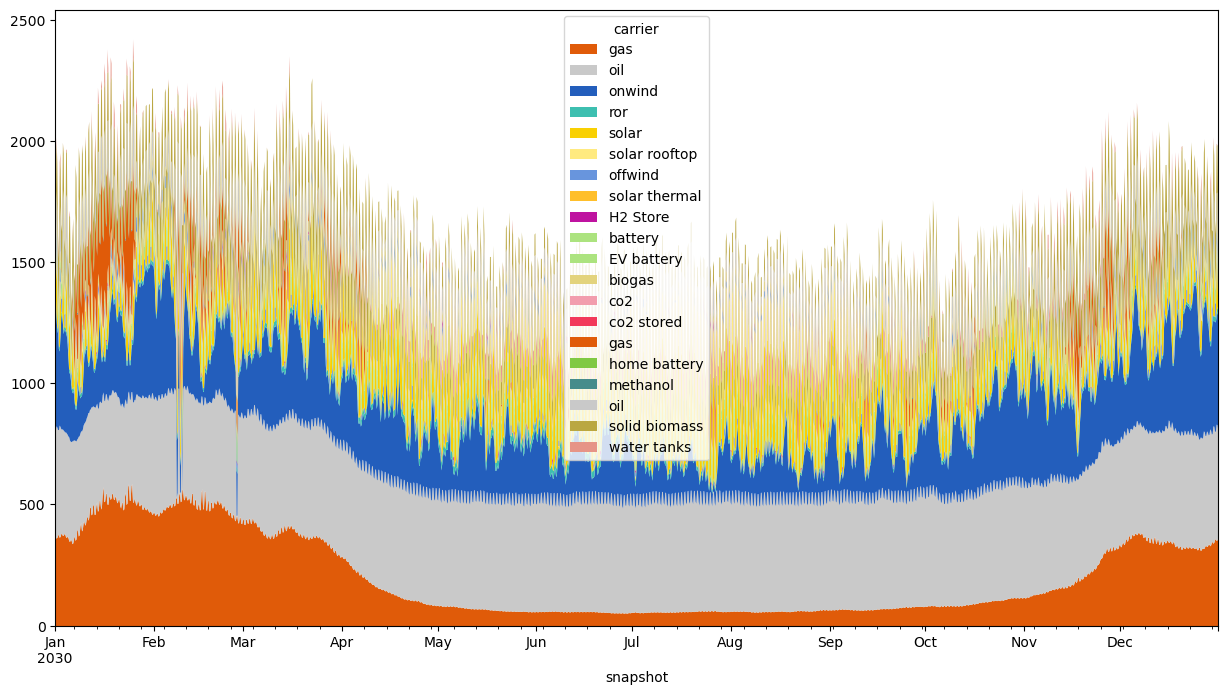

In [17]:
plot_dispatch(n2, time="2030")

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_39807/430977326.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_39807/430977326.py:22: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



ValueError: When stacked is True, each column must be either all positive or all negative. Column 'H2 Store' contains both positive and negative values

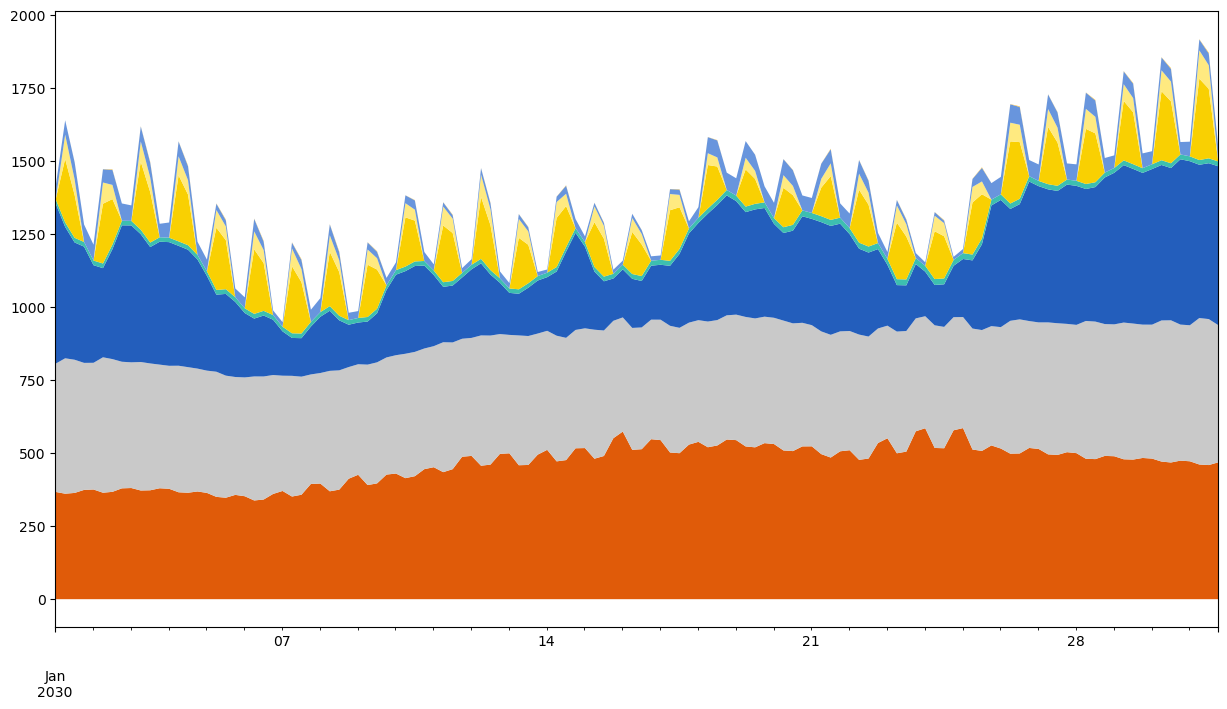

In [10]:
plot_dispatch(n2, time="2030-01")

In [26]:
wind2=n2.generators_t.p.filter(like='wind').filter(like="DE").div(1e3).sum(axis=1)
solar2=n2.generators_t.p.filter(like='solar').filter(like="DE").div(1e3).sum(axis=1)
ror2=n2.generators_t.p.filter(like='ror').filter(like="DE").div(1e3).sum(axis=1)

load2=n2.loads_t.p_set.filter(like="DE").div(1e3).sum(axis=1)
h2_demand2=n2.loads_t.p.filter(like="H2").filter(like="DE").div(1e3).sum(axis=1)
h2_supply2=n2.links_t.p1.filter(like="H2").filter(like="DE").div(1e3).sum(axis=1)

h2_dispatch2=n2.stores_t.p.filter(like="H2").filter(like="DE").div(1e3).sum(axis=1)
h2_store_level2=n2.stores_t.e.filter(like="H2").filter(like="DE").div(1e3).sum(axis=1)
h2_store_max2=n2.stores.e_nom_opt.filter(like="H2").filter(like="DE").div(1e3).sum()
h2_SOC2=h2_store_level2/h2_store_max2*100

battery_dispatch2=n2.stores_t.p.filter(like="battery").filter(like="DE").div(1e3).sum(axis=1)# GW
battery_level2=n2.stores_t.e.filter(like="battery").filter(like="DE").div(1e3).sum(axis=1)
battery_max2=n2.stores.e_nom_opt.filter(like="battery").filter(like="DE").div(1e3).sum()
battery_SOC2=battery_level2/battery_max2*100

watertank_dispatch2=n2.stores_t.p.filter(like="water tanks").filter(like="DE").div(1e3).sum(axis=1)# GW
watertank_level2=n2.stores_t.e.filter(like="water tanks").filter(like="DE").div(1e3).sum(axis=1)
watertank_max2=n2.stores.e_nom_opt.filter(like="water tanks").filter(like="DE").div(1e3).sum()
watertank_SOC2=watertank_level2/watertank_max2*100


hydro_dispatch2=n2.storage_units_t.p.filter(like="hydro").filter(like="DE").div(1e3).sum(axis=1)# GW
hydro_level2=n2.storage_units_t.state_of_charge.filter(like="hydro").filter(like="DE").div(1e3).sum(axis=1)
hydro_max2=hydro_level2.max()
hydro_SOC2=hydro_level2/hydro_max2*100

PHS_dispatch2=n2.storage_units_t.p.filter(like="PHS").filter(like="DE").div(1e3).sum(axis=1)# GW
PHS_level2=n2.storage_units_t.state_of_charge.filter(like="PHS").filter(like="DE").div(1e3).sum(axis=1)
PHS_max2=PHS_level2.max()
PHS_SOC2=PHS_level2/PHS_max2*100



In [28]:
# create time series dataframe in Germany for case 2
ts2 = pd.DataFrame(wind2)
ts2 = ts2.rename(columns={0:'wind [GW]'})
ts2["solar [GW]"] = solar2
ts2["ror [GW]"] = ror2
ts2["load [GW]"] = load2
ts2["h2 demand [GW]"] = h2_demand2
ts2["h2 supply [GW]"] = h2_supply2
ts2["h2 dispatch [GW]"] = h2_dispatch2
ts2["h2 SOC [%]"] = h2_SOC2
ts2["battery dispatch [GW]"] = battery_dispatch2
ts2["battery SOC [%]"] = battery_SOC2

ts2["hot water disptach [GW]"] = watertank_dispatch2
ts2["hot water SOC [%]"] = watertank_SOC2

ts2["hydro disptach [GW]"] = hydro_dispatch2
ts2["hydro SOC [%]"] = hydro_SOC2

ts2["PHS dispatch [GW]"] = PHS_dispatch2
ts2["PHS SOC [%]"] = PHS_SOC2
#ts2["solar residual load"] = ts2["load [GW]"] - ts2["solar [GW]"]
#ts2["wind residual load"] = ts2["load [GW]"] - ts2["wind [GW]"]

ts2["solar residual load"] = ts2["h2 demand [GW]"] - ts2["solar [GW]"]
ts2["wind residual load"] = ts2["h2 demand [GW]"] - ts2["wind [GW]"]

ts2.index = pd.to_datetime(ts2.index)
ts2.index = ts2.index.map(lambda x: x.replace(year=2030))
ts2


wind [GW]  solar [GW]  ror [GW]   load [GW]  \
snapshot                                                            
2030-01-01 00:00:00  116.102733    0.000000  2.241712  133.316986   
2030-01-01 06:00:00   88.856011   14.301853  2.295932  201.355333   
2030-01-01 12:00:00   71.155142    6.819307  2.414874  206.035790   
2030-01-01 18:00:00   78.669272    0.000000  2.449836  143.042075   
2030-01-02 00:00:00   84.703378    0.000000  2.436448  147.596943   
...                         ...         ...       ...         ...   
2030-12-30 18:00:00   96.697782    0.000000  2.163027  168.908543   
2030-12-31 00:00:00   75.673048    0.000000  2.168611  162.304172   
2030-12-31 06:00:00   58.775140   42.450721  2.173535  241.250474   
2030-12-31 12:00:00   69.638094   26.564197  2.176193  240.121530   
2030-12-31 18:00:00   88.914476    0.000000  2.178239  169.814423   

                     h2 demand [GW]  h2 supply [GW]  h2 dispatch [GW]  \
snapshot                                                                
2030-01-01 00:00:00        2.155251      -10.443175         -2.769061   
2030-01-01 06:00:00        2.155251       -8.594807         -1.747536   
2030-01-01 12:00:00        2.155251       -5.433501          1.268620   
2030-01-01 18:00:00        2.155251      -10.460146         -2.705204   
2030-01-02 00:00:00        2.155251      -10.464600         -2.771929   
...                             ...             ...               ...   
2030-12-30 18:00:00        2.155251      -10.442704         -2.706416   
2030-12-31 00:00:00        2.155251      -10.439372         -2.754967   
2030-12-31 06:00:00        2.155251       -8.424456         -1.636782   
2030-12-31 12:00:00        2.155251       -8.274246         -1.549807   
2030-12-31 18:00:00        2.155251      -10.448985         -2.692869   

                     h2 SOC [%]  battery dispatch [GW]  battery SOC [%]  \
snapshot                                                                  
2030-01-01 00:00:00   69.268811             -12.217521        78.515397   
2030-01-01 06:00:00   71.014334              -9.024182        98.373099   
2030-01-01 12:00:00   69.747176               2.144719        93.653646   
2030-01-01 18:00:00   72.449262               2.426785        88.313508   
2030-01-02 00:00:00   75.217996               1.510406        84.989863   
...                         ...                    ...              ...   
2030-12-30 18:00:00   57.878467               7.804214        59.943900   
2030-12-31 00:00:00   60.630259               2.402044        54.658205   
2030-12-31 06:00:00   62.265155              -9.690841        75.982889   
2030-12-31 12:00:00   63.813176               6.942438        60.706062   
2030-12-31 18:00:00   66.502942               4.124204        51.630755   

                     hot water disptach [GW]  hot water SOC [%]  \
snapshot                                                          
2030-01-01 00:00:00                -2.752475          10.501205   
2030-01-01 06:00:00                 3.271307           9.633973   
2030-01-01 12:00:00                 1.991741           9.107348   
2030-01-01 18:00:00                -0.135061           9.102872   
2030-01-02 00:00:00                 2.055063           8.523323   
...                                      ...                ...   
2030-12-30 18:00:00                -0.759319          11.367862   
2030-12-31 00:00:00                -0.313582          11.422705   
2030-12-31 06:00:00                 4.175317          10.365151   
2030-12-31 12:00:00                 2.187534           9.810124   
2030-12-31 18:00:00                -0.187921           9.842645   

                     hydro disptach [GW]  hydro SOC [%]  PHS dispatch [GW]  \
snapshot                                                                     
2030-01-01 00:00:00               0.1695      15.508450          -4.062641   
2030-01-01 06:00:00               0.1695      15.421785          -0.911773   
2030-01-01 12:

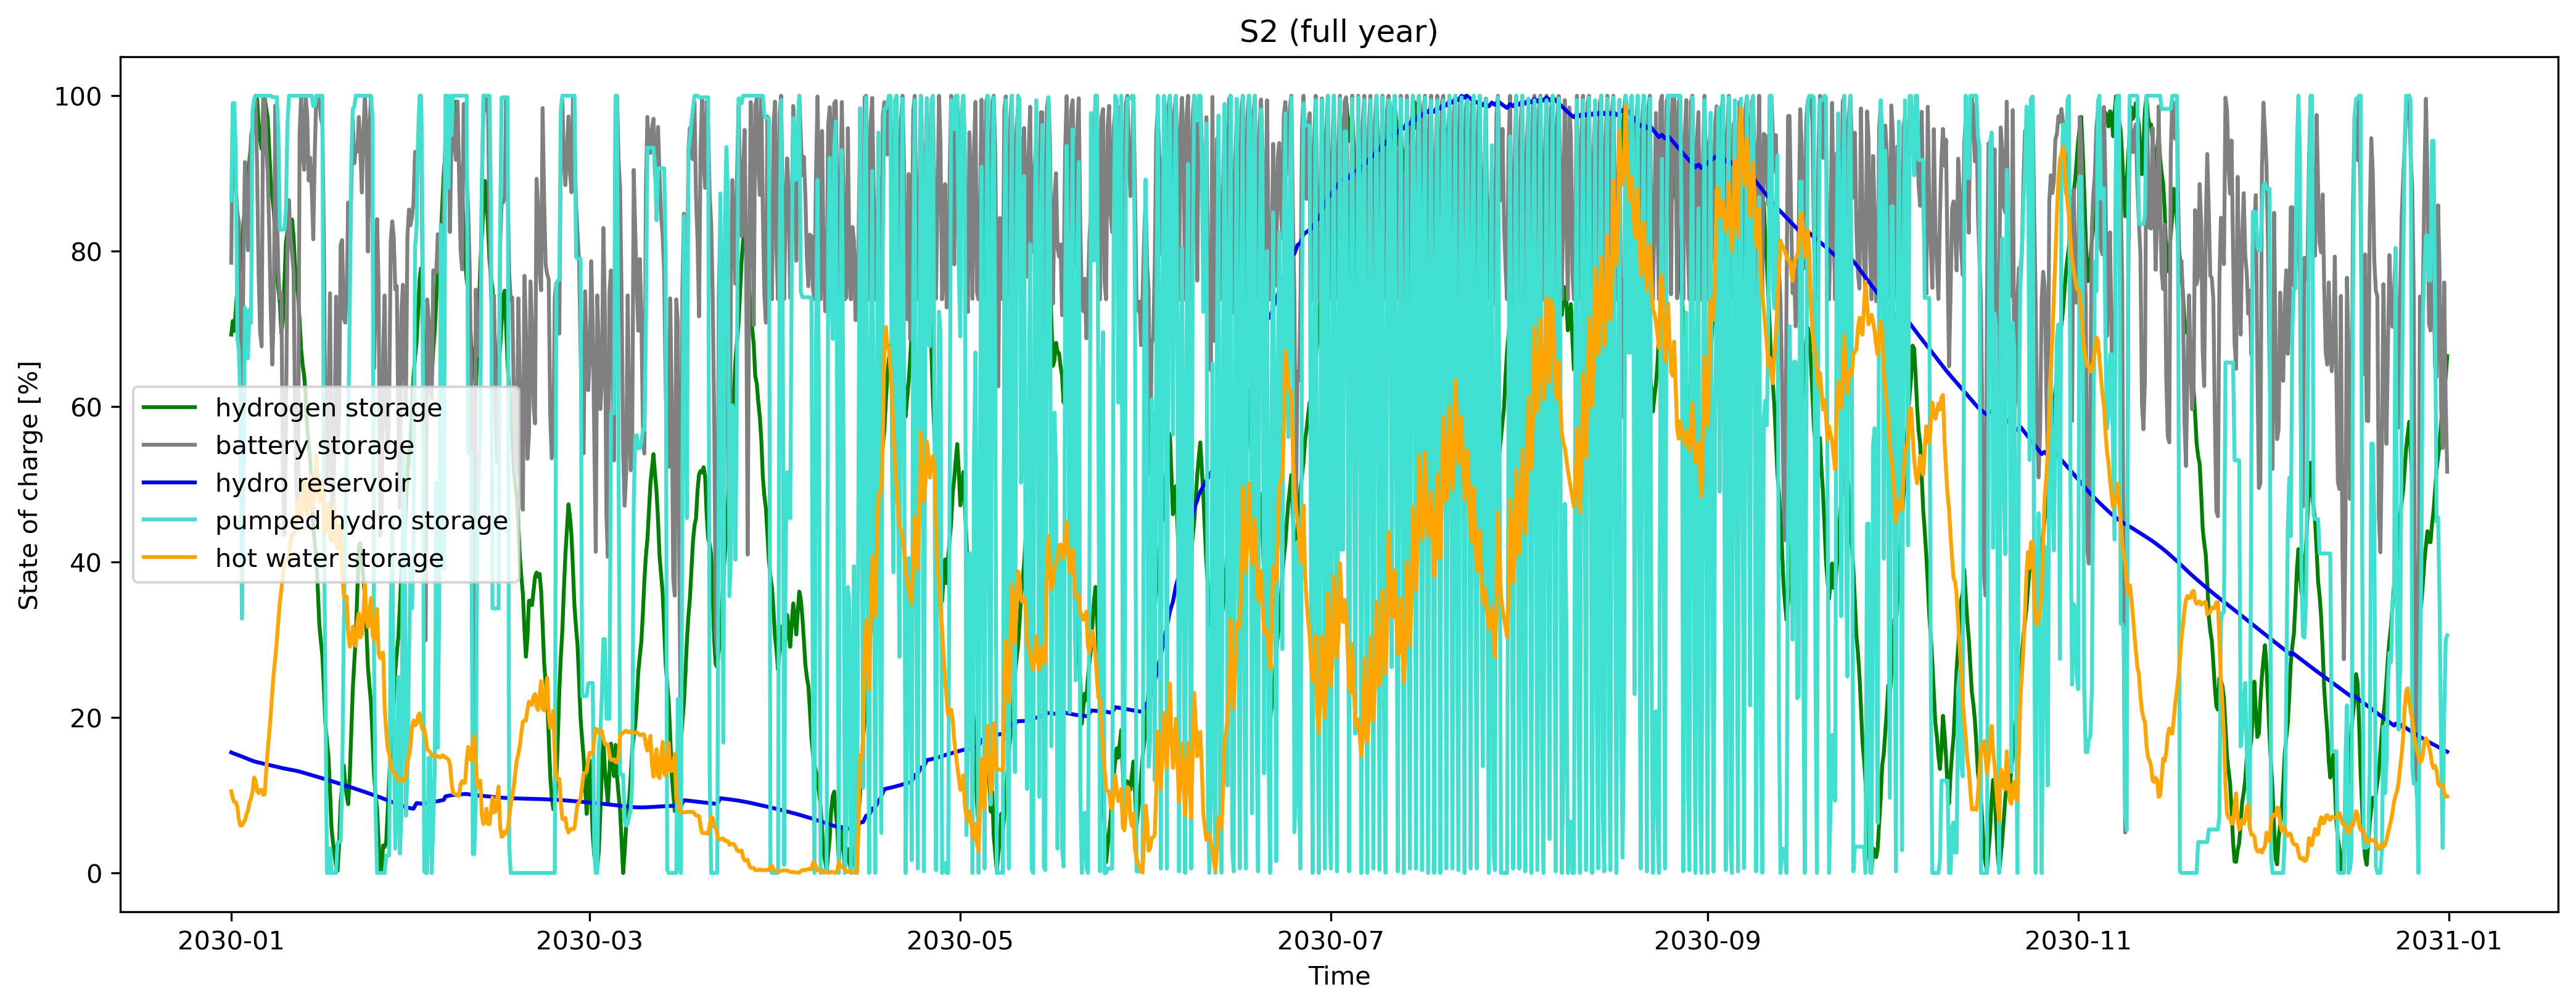

In [29]:
plt.figure(figsize=(17, 6),dpi=300)
plt.plot(ts2["h2 SOC [%]"], color="green", label="hydrogen storage")
plt.plot(ts2["battery SOC [%]"], color="grey", label="battery storage")
plt.plot(ts2["hydro SOC [%]"], color="blue", label="hydro reservoir")
plt.plot(ts2["PHS SOC [%]"], color="turquoise", label="pumped hydro storage")
plt.plot(ts2["hot water SOC [%]"], color="orange", label="hot water storage")
#plt.fill_between(ts2["deficit [GW]"].loc["2030-01"].index, ts2["load [GW]"].loc["2030-01"], ts2["RE"].loc["2030-01"], color="grey", label="deficit")
#plt.fill_between(ts2.index, ts2["load [TW]"].loc["2013-01"], ts2["RE"].loc["2013-01"], color="grey", label="deficit")

plt.xlabel("Time")
plt.ylabel("State of charge [%]")
plt.title("S2 (full year)")
plt.legend()
plt.show()

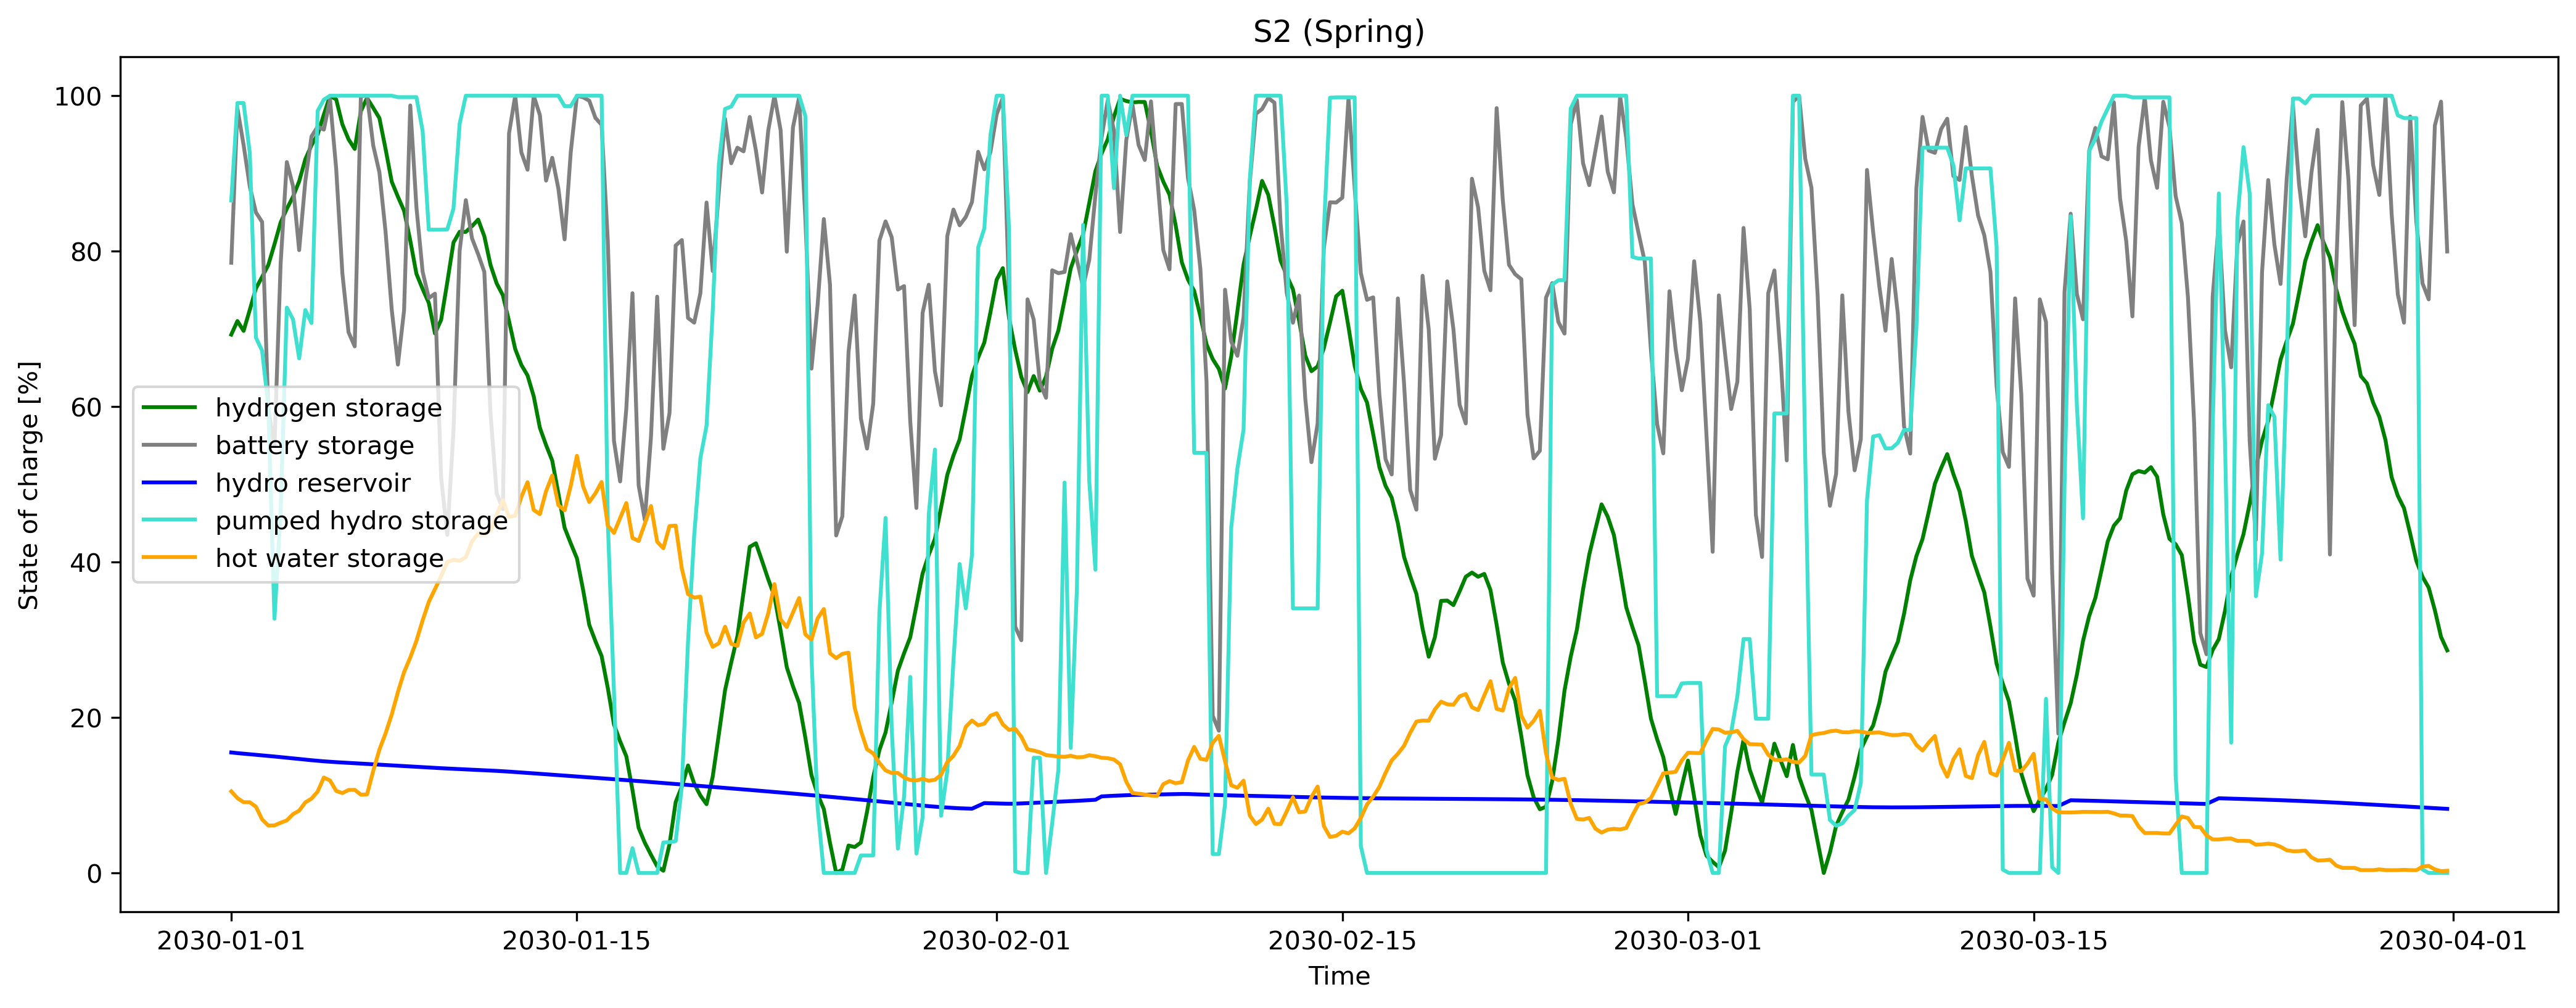

In [30]:
plt.figure(figsize=(17, 6),dpi=300)
plt.plot(ts2["h2 SOC [%]"].loc["2030-01":"2030-03"], color="green", label="hydrogen storage")
plt.plot(ts2["battery SOC [%]"].loc["2030-01":"2030-03"], color="grey", label="battery storage")
plt.plot(ts2["hydro SOC [%]"].loc["2030-01":"2030-03"], color="blue", label="hydro reservoir")
plt.plot(ts2["PHS SOC [%]"].loc["2030-01":"2030-03"], color="turquoise", label="pumped hydro storage")
plt.plot(ts2["hot water SOC [%]"].loc["2030-01":"2030-03"], color="orange", label="hot water storage")


#plt.fill_between(ts2["deficit [GW]"].loc["2030-01"].index, ts2["load [GW]"].loc["2030-01"], ts2["RE"].loc["2030-01"], color="grey", label="deficit")
#plt.fill_between(ts2.index, ts2["load [TW]"].loc["2013-01"], ts2["RE"].loc["2013-01"], color="grey", label="deficit")

plt.xlabel("Time")
plt.ylabel("State of charge [%]")
plt.title("S2 (Spring)")
plt.legend()
plt.show()

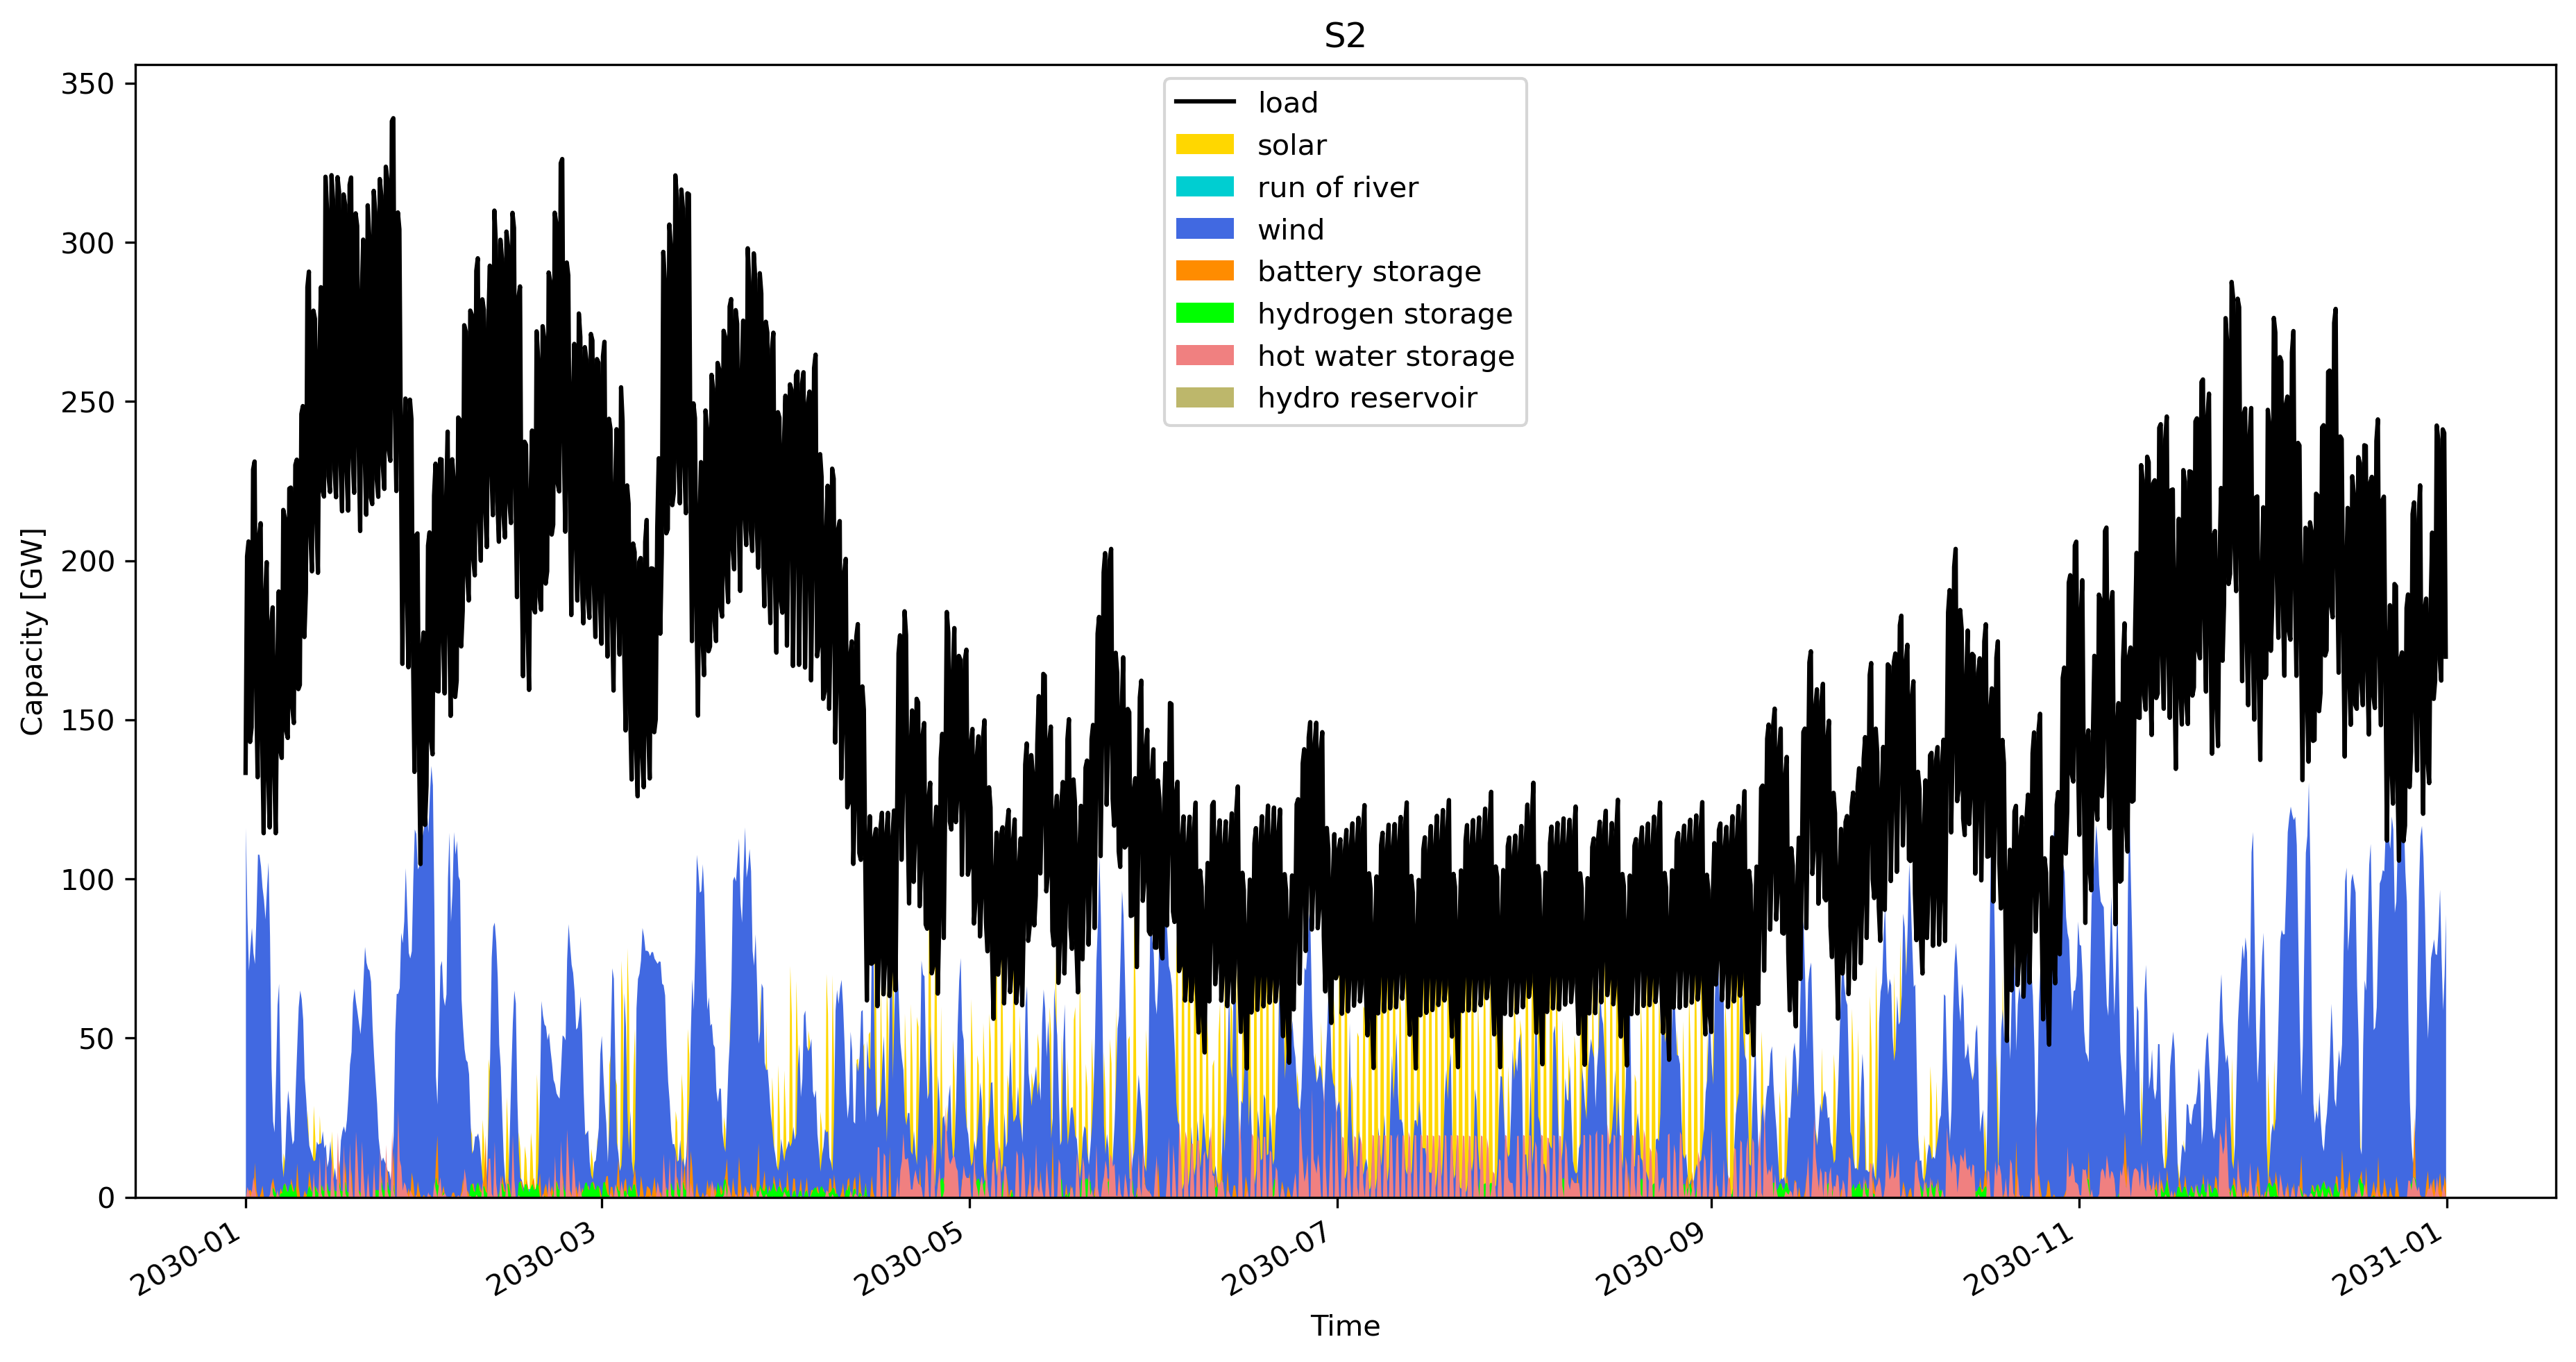

In [31]:
fig, ax = plt.subplots(figsize=(15, 8),dpi=300)
plt.plot(ts2["load [GW]"], color="black", label="load")
ts2["solar [GW]"].plot.area(ax=ax,linewidth=0,color="gold",label="solar")
ts2["ror [GW]"].plot.area(ax=ax,linewidth=0,color="darkturquoise",label="run of river")
ts2["wind [GW]"].plot.area(ax=ax,linewidth=0,color="royalblue",label="wind")
ts2["battery dispatch [GW]"].where(ts2["battery dispatch [GW]"]>0).plot.area(ax=ax,linewidth=0,color="darkorange",label="battery storage")
ts2["h2 dispatch [GW]"].where(ts2["h2 dispatch [GW]"]>0).plot.area(ax=ax,linewidth=0,color="lime",label="hydrogen storage")
ts2["hot water disptach [GW]"].where(ts2["hot water disptach [GW]"]>0).plot.area(ax=ax,linewidth=0,color="lightcoral",label="hot water storage")
ts2["hydro disptach [GW]"].where(ts2["hydro disptach [GW]"]>0).plot.area(ax=ax,linewidth=0,color="darkkhaki",label="hydro reservoir")
#ts2["PHS disptach [GW]"].where(ts2["PHS disptach [GW]"]>0).plot.area(ax=ax,linewidth=0,color="darkkhaki",label="pumped hydro storage")


#plt.plot(ts2["load [GW]"], color="black", label="load")

plt.xlabel("Time")
plt.ylabel("Capacity [GW]")
plt.title("S2")
plt.legend()
plt.show()

In [37]:
sab2 = n2.links_t.p0.filter(regex='^DE.*Sabatier$').sum(axis=1) # MW
sab2.index = pd.to_datetime(sab2.index)
sab2.index = sab2.index.map(lambda dt: dt.replace(year=2030))
#pct3_home_battery = sab3/(0.638464)*100
#pct3_home_battery = pct3_home_battery.to_frame(name="FNB")
sab2.sum()

5.649715892095342

In [38]:
ft2 = n2.links_t.p0.filter(regex='^DE.*Fischer-Tropsch$').sum(axis=1) # MW
ft2.index = pd.to_datetime(ft2.index)
ft2.index = ft2.index.map(lambda dt: dt.replace(year=2030))
#pct3_home_battery = sab3/(0.638464)*100
#pct3_home_battery = pct3_home_battery.to_frame(name="FNB")
ft2.sum()

27.796108818722917

In [39]:
fc2 = n2.links_t.p0.filter(regex='^DE.*H2 Fuel Cell$').sum(axis=1) # MW
fc2.index = pd.to_datetime(fc2.index)
fc2.index = fc2.index.map(lambda dt: dt.replace(year=2030))
#pct3_home_battery = sab3/(0.638464)*100
#pct3_home_battery = pct3_home_battery.to_frame(name="FNB")
fc2.sum()

9.717747896448472